# Project

In [1]:
%matplotlib inline
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_ext_filter
import tdmclient.notebook
await tdmclient.notebook.start()


In [2]:
# parametres
speed_r = 100
speed_f = 100
stop = 0
MIN_DIST = 40
ANGLE_TOLERANCE = 0.30
PERIOD = 0.25
SPEED_AVG = 100
ROBOT_SPEED_TO_MM = 140/500

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

nb_samples = int(2/PERIOD)
prox_int = np.zeros((1,nb_samples))

def prox():
    global prox_horizontal

    turn = (prox_horizontal[0] //2 + prox_horizontal[1] - prox_horizontal[3] - prox_horizontal[4] //2) //40

    #adding integral term
    ki = np.array(range(nb_samples))/10
    prox_int = np.append(prox_int,turn)
    prox_int = np.delete(prox_int, 0)
    turn += ki*prox_int

    return turn

In [3]:
def controller(goal_dist, angle):
    kp_rot = 100
    kp_lin = 3

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l = 80 - kp_rot*(angle) + prox()
        speed_r = 80 + kp_rot*(angle) - prox()
    else:
        speed_l = SPEED_AVG + prox()
        speed_r = SPEED_AVG - prox()
    return speed_l, speed_r

In [4]:
def pathing (video_capture, filter, path, x0, y0, theta0, periode=0.01):
    # plot for camera, kalman and error
    teta = np.zeros(np.shape(path)[0])
    speed_l = speed_r = 0
    goalx = path[0][0]
    goaly = path[0][1]
    
    i = 0
    curr_time = 0
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    j=0
    while True:       
        #   step 1: get the image, detect the robot, and get the position
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    
                    position_measure = invert_coordinates(position_measure)
                    position_measure[0:2] = pixel_to_metric(position_measure[0:2])
                    theta_measure = wrap_angle(theta_measure)
                    [kx, ky, kteta] = [position_measure[0], position_measure[1], -theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False

        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        [pred_x, pred_y, pred_teta], _, curr_time = filter.filter(measurement, curr_time) 
        
        dist = distance (goalx, goaly, kx, ky)
        teta[i] = math.atan2((goaly - ky), (goalx - kx)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
                vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
                vec2 = [goalx - kx, goaly - ky]
                angle = get_angle_between(vec1, vec2)
            else:
                motors(stop, stop)
                break
        else :
            angle =  wrap_angle((teta[i] - kteta) % (2*np.pi))
            
            speed_l, speed_r = controller(dist, angle)
            #speed_l  = SPEED_AVG
            #speed_r = SPEED_AVG
        
        # set input for kalman filter
        filter.u = np.array([speed_l, speed_r]) * ROBOT_SPEED_TO_MM
        motors(int(speed_l),int(speed_r))

        
        #print(i, camera_available, dist, position_measure, angle, teta[i], kteta)
        
        #print("camera : %.3f %.3f %.4f" %(kx, ky, kteta))
        #print("kalman : %.3f %.3f %.4f" %(pred_x, pred_y, pred_teta))
        print(i, filter.dt, "error :%d %.3f %.3f %.4f" %(j, kx-pred_x, ky-pred_y, kteta-pred_teta))
         
        #cv2.imshow("frame", cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    motors(stop, stop)
    

# Main 

1
2
3
start = [155.479 253.405] goal = [1029.082  606.454]


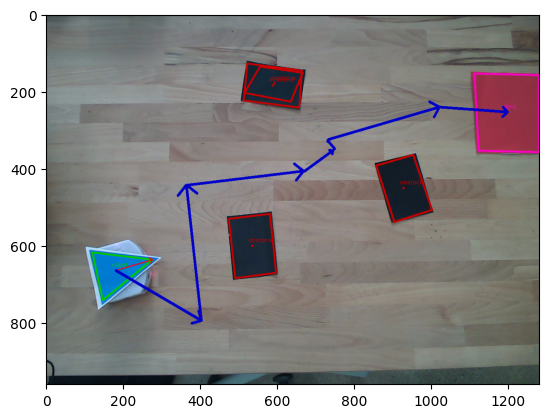

In [5]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-8)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)
    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    filter = kalman_ext_filter(metric_start[0], metric_start[1], -robot[2], 0, 0, PERIOD)
    print('start =', metric_start, 'goal =', metric_goal)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)

motors(stop, stop)
np.shape(path)
print(np.shape(path)[0])

12


In [7]:
pathing(video_capture, filter, metric_path, metric_start[0], metric_start[1], -robot[2], periode=PERIOD)
print("finished")
motors(stop, stop)

1 0.25 error :0 0.000 0.000 0.0000
1 0.22499966621398926 error :0 0.000 0.000 0.0000
1 0.23900294303894043 error :0 -3.490 -1.029 0.0718
1 0.23999834060668945 error :0 -6.415 -1.891 0.1438
1 0.24699950218200684 error :0 -5.710 -3.383 0.1539
1 0.22899961471557617 error :0 -3.260 -5.497 0.1388
1 0.23499679565429688 error :0 -1.984 -8.201 0.0912
1 0.22700262069702148 error :0 -0.889 -11.483 0.0454
1 0.20800113677978516 error :0 -0.620 -14.562 -0.0031
1 0.23199939727783203 error :0 -0.279 -19.029 -0.0498
1 0.23299860954284668 error :0 -5.929 -24.348 -0.1372
1 0.246002197265625 error :0 -7.649 -29.321 -0.1836
1 0.23400020599365234 error :0 -7.488 -34.845 -0.2024
1 0.242997407913208 error :0 -2.112 -40.274 -0.1738
1 0.2180006504058838 error :0 -1.013 -45.518 -0.1641
1 0.2240009307861328 error :0 -0.551 -52.982 -0.1578
1 0.23401117324829102 error :0 0.778 -58.573 -0.1424
1 0.23698854446411133 error :0 3.468 -60.866 -0.1204
1 0.21999859809875488 error :0 7.747 -66.071 -0.0902
1 0.2219998836517

KeyboardInterrupt: 